#data and importations


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import chi2_contingency, pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

apps_data = pd.read_csv('googleplaystore.csv')
reviews_data = pd.read_csv('googleplaystore_user_reviews.csv')

print("Google Play Store Apps Dataset:\n")
print("Columns:", apps_data.columns.tolist())
print("Shape:", apps_data.shape)
print("First 5 Rows:\n", apps_data.head())
print("\nMissing Values:\n", apps_data.isnull().sum())



print("\nUnique Categories in Apps Dataset:", apps_data['Category'].unique())
print("\nUnique Sentiments in Reviews Dataset:", reviews_data['Sentiment'].unique())

Google Play Store Apps Dataset:

Columns: ['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver']
Shape: (10841, 13)
First 5 Rows:
                                                  App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

  Reviews  Size     Installs  Type Price Content Rating  \
0     159   19M      10,000+  Free     0       Everyone   
1     967   14M     500,000+  Free     0       Everyone   
2   87510  8.7M   5,000,000+  Free     0       Everyone   
3  215644   25M  50,000,000+  Free     0           Teen

In [ ]:
print("Google Play Store Apps Dataset:\n")
print("Shape:", apps_data.shape)
print("First 5 Rows:\n", apps_data.head())
print("\nMissing Values:\n", apps_data.isnull().sum())

Google Play Store Apps Dataset:

Shape: (10841, 13)
First 5 Rows:
                                                  App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

  Reviews  Size     Installs  Type Price Content Rating  \
0     159   19M      10,000+  Free     0       Everyone   
1     967   14M     500,000+  Free     0       Everyone   
2   87510  8.7M   5,000,000+  Free     0       Everyone   
3  215644   25M  50,000,000+  Free     0           Teen   
4     967  2.8M     100,000+  Free     0       Everyone   

                      Genres      Last Updated         Current Ver  \
0               Art & Desig

In [ ]:
print("\nGoogle Play Store User Reviews Dataset:\n")
print("Shape:", reviews_data.shape)
print("First 5 Rows:\n", reviews_data.head())
print("\nMissing Values:\n", reviews_data.isnull().sum())


Google Play Store User Reviews Dataset:

Shape: (64295, 5)
First 5 Rows:
                      App                                  Translated_Review  \
0  10 Best Foods for You  I like eat delicious food. That's I'm cooking ...   
1  10 Best Foods for You    This help eating healthy exercise regular basis   
2  10 Best Foods for You                                                NaN   
3  10 Best Foods for You         Works great especially going grocery store   
4  10 Best Foods for You                                       Best idea us   

  Sentiment  Sentiment_Polarity  Sentiment_Subjectivity  
0  Positive                1.00                0.533333  
1  Positive                0.25                0.288462  
2       NaN                 NaN                     NaN  
3  Positive                0.40                0.875000  
4  Positive                1.00                0.300000  

Missing Values:
 App                           0
Translated_Review         26868
Sentiment           

#Data Cleaning

In [ ]:
apps_data['Rating'] = apps_data['Rating'].fillna(apps_data['Rating'].mean())
apps_data = apps_data.fillna({'Content Rating': 'Unknown', 'Type': 'Free'})
reviews_data = reviews_data.fillna({'Translated_Review': 'No Review', 'Sentiment': 'Neutral'})

def convert_size(size):
    if isinstance(size, str):
        size = size.strip()
        if 'M' in size:
            return float(size.replace('M', ''))
        elif 'k' in size:
            return float(size.replace('k', '')) / 1024
        elif size == "Varies with device":
            return None
    return None

apps_data['Size'] = apps_data['Size'].apply(convert_size)
apps_data['Size'] = pd.to_numeric(apps_data['Size'], errors='coerce')
apps_data['Installs'] = apps_data['Installs'].astype(str).replace('[+,]', '', regex=True)
apps_data['Installs'] = pd.to_numeric(apps_data['Installs'], errors='coerce').fillna(0).astype(int)

q1, q3 = apps_data['Installs'].quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

apps_data = apps_data[(apps_data['Installs'] >= lower_bound) & (apps_data['Installs'] <= upper_bound)]


In [ ]:
bins = [0, 2, 4, 5]
apps_data['Rating_Binned'] = pd.cut(apps_data['Rating'], bins=bins, labels=['Low', 'Average', 'High'])


X = apps_data[['Reviews', 'Size', 'Installs']].dropna()
y = apps_data.loc[X.index, 'Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
regressor = LinearRegression().fit(X_train, y_train)
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Regression MSE:", mse)


Regression MSE: 0.2413489661741904


In [ ]:
apps_data['Installs'] = apps_data['Installs'].replace(r'[^\d]', '', regex=True).astype(float)
apps_data['Reviews'] = apps_data['Reviews'].replace(r'[^\d]', '', regex=True).astype(float)
apps_data['Rating'] = pd.to_numeric(apps_data['Rating'], errors='coerce')

apps_data = apps_data.dropna(subset=['Installs', 'Reviews', 'Rating'])

scaled_data = MinMaxScaler().fit_transform(apps_data[['Installs', 'Reviews', 'Rating']])

kmeans = KMeans(n_clusters=4, random_state=42)
apps_data['Cluster'] = kmeans.fit_predict(scaled_data)

outlier

In [ ]:
outlier_rows = apps_data[apps_data['Rating'] > 6]

print(outlier_rows)

                                           App Category  Rating  Reviews  \
10472  Life Made WI-Fi Touchscreen Photo Frame      1.9    19.0     30.0   

       Size  Installs Type     Price Content Rating             Genres  \
10472   NaN       0.0    0  Everyone        Unknown  February 11, 2018   

      Last Updated Current Ver Android Ver Rating_Binned  Cluster  
10472       1.0.19  4.0 and up         NaN           NaN        3  


# Central Tendency Metrics

In [ ]:
numerical_columns = ['Reviews', 'Size', 'Installs']

central_tendency = {}
dispersion = {}
skewness = {}

for column in numerical_columns:
    data = apps_data[column].dropna()

    central_tendency[column] = {
        'Mean': data.mean(),
        'Median': data.median(),
        'Mode': data.mode().iloc[0] if not data.mode().empty else np.nan
    }

    dispersion[column] = {
        'Range': data.max() - data.min(),
        'IQR': data.quantile(0.75) - data.quantile(0.25),
        'Variance': data.var(),
        'Standard Deviation': data.std()
    }

    skewness[column] = {
        'Symmetry': 'Symmetric' if abs(data.mean() - data.median()) < 0.01 else 'Skewed'
    }

central_tendency_df = pd.DataFrame(central_tendency).T
dispersion_df = pd.DataFrame(dispersion).T
skewness_df = pd.DataFrame(skewness).T

print("Central Tendency Metrics:\n", central_tendency_df, "\n")
print("Dispersion Metrics:\n", dispersion_df, "\n")
print("Skewness Metrics:\n", skewness_df)


Central Tendency Metrics:
                   Mean    Median       Mode
Reviews   5.927577e+04    1115.0        0.0
Size      2.037206e+01      12.0       12.0
Installs  1.825970e+06  100000.0  1000000.0 

Dispersion Metrics:
                  Range       IQR      Variance  Standard Deviation
Reviews   3.093932e+06   29303.0  3.330170e+10        1.824875e+05
Size      9.999170e+01      23.3  4.674763e+02        2.162120e+01
Installs  1.000000e+07  999000.0  1.122071e+13        3.349733e+06 

Skewness Metrics:
          Symmetry
Reviews    Skewed
Size       Skewed
Installs   Skewed


In [ ]:
numerical_columns = ['Rating', 'Reviews', 'Size', 'Installs']
cov_matrix = apps_data[numerical_columns].cov()

corr_matrix = apps_data[numerical_columns].corr()

print("Covariance Matrix:")
print(cov_matrix)

print("\nCorrelation Matrix:")
print(corr_matrix)




Covariance Matrix:
                 Rating       Reviews          Size      Installs
Rating         0.264161  1.308047e+04  6.272463e-01  1.984085e+05
Reviews    13080.468428  3.330170e+10  7.576187e+05  3.892198e+11
Size           0.627246  7.576187e+05  4.674763e+02  1.604550e+07
Installs  198408.521572  3.892198e+11  1.604550e+07  1.122071e+13

Correlation Matrix:
            Rating   Reviews      Size  Installs
Rating    1.000000  0.139462  0.057062  0.115243
Reviews   0.139462  1.000000  0.229370  0.636725
Size      0.057062  0.229370  1.000000  0.246848
Installs  0.115243  0.636725  0.246848  1.000000


App with most reviews: Angry Birds Classic
Number of Reviews: 320

Central Tendency Metrics for Sentiment_Polarity:
Mean: 0.18214631382977461, Median: 0.15, Mode: 0.0


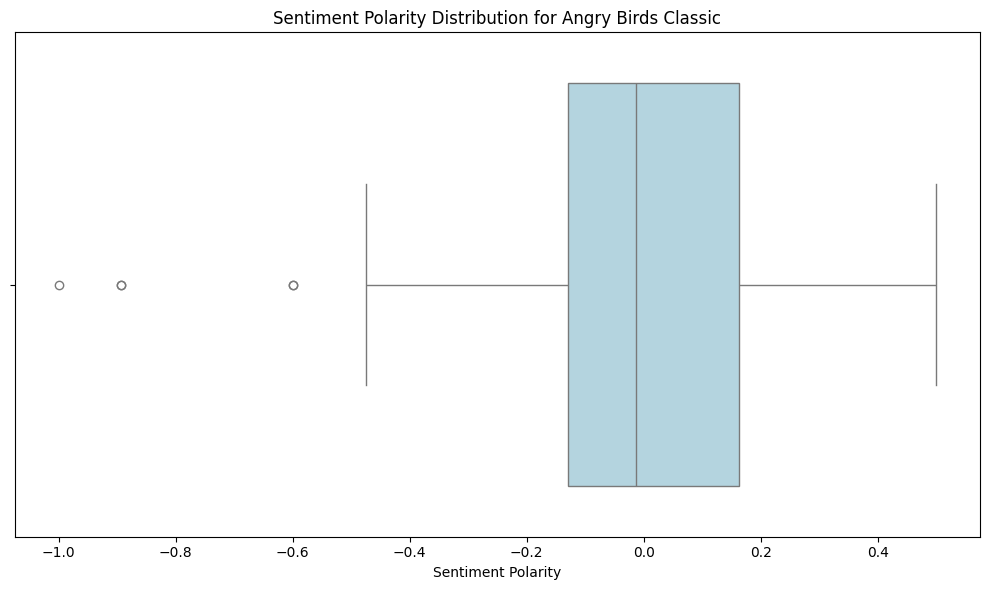

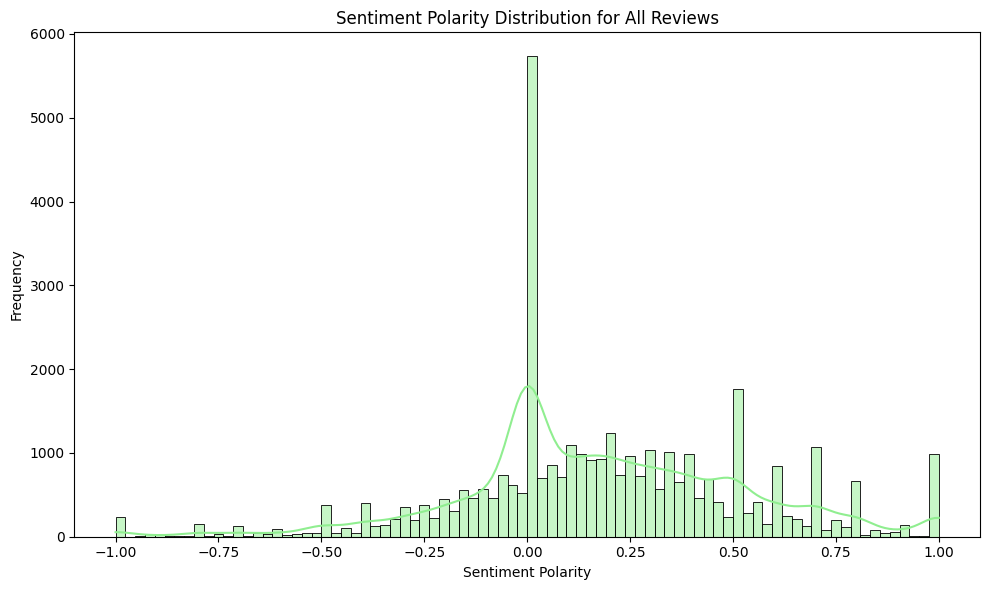

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

review_counts = reviews_data['App'].value_counts()
most_reviews_app_name = review_counts.idxmax()
most_reviews_app_data = reviews_data[reviews_data['App'] == most_reviews_app_name]

print(f"App with most reviews: {most_reviews_app_name}")
print(f"Number of Reviews: {review_counts.max()}")

sentiment_polarity = reviews_data['Sentiment_Polarity']

sentiment_mean = sentiment_polarity.mean()
sentiment_median = sentiment_polarity.median()
sentiment_mode = sentiment_polarity.mode()[0]

print("\nCentral Tendency Metrics for Sentiment_Polarity:")
print(f"Mean: {sentiment_mean}, Median: {sentiment_median}, Mode: {sentiment_mode}")

plt.figure(figsize=(10, 6))

sns.boxplot(data=most_reviews_app_data, x='Sentiment_Polarity', color='lightblue')
plt.title(f'Sentiment Polarity Distribution for {most_reviews_app_name}')
plt.xlabel('Sentiment Polarity')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

sns.histplot(sentiment_polarity, kde=True, color='lightgreen')
plt.title('Sentiment Polarity Distribution for All Reviews')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [ ]:
reviews_data.head(1)

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.0,0.533333


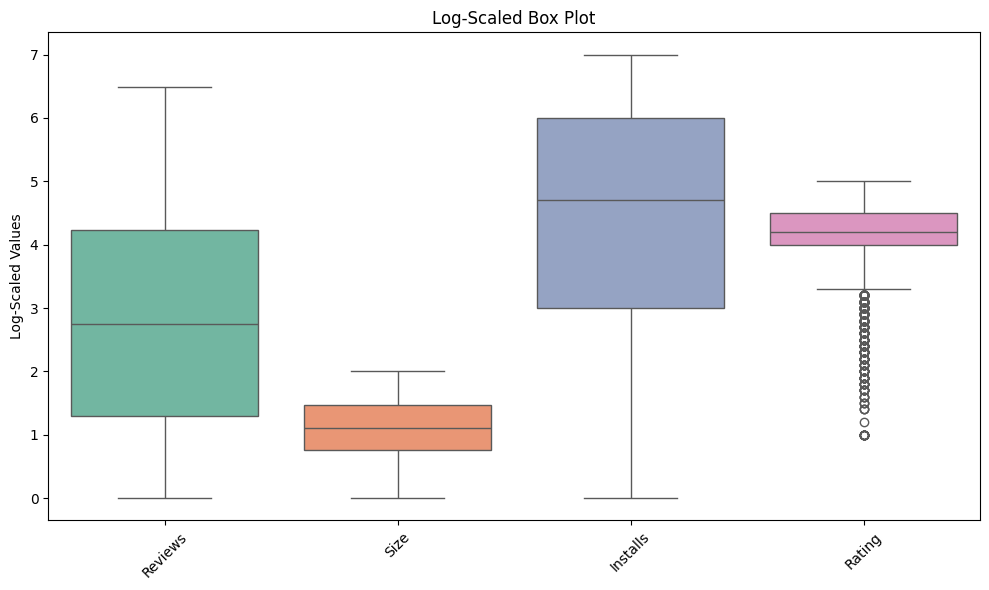

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

numerical_columns = ['Reviews', 'Size', 'Installs', 'Rating']

transformed_data = apps_data[numerical_columns].dropna().copy()
transformed_data['Reviews'] = np.log10(transformed_data['Reviews'] + 1)
transformed_data['Installs'] = np.log10(transformed_data['Installs'] + 1)
transformed_data['Size'] = np.log10(transformed_data['Size'] + 1)
transformed_data['Rating'] = apps_data['Rating']

plt.figure(figsize=(10, 6))
sns.boxplot(data=transformed_data, palette="Set2")
plt.title('Log-Scaled Box Plot')
plt.ylabel('Log-Scaled Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Q1 = transformed_data.quantile(0.25)
Q3 = transformed_data.quantile(0.75)
IQR = Q3 - Q1

outliers = (transformed_data < (Q1 - 1.5 * IQR)) | (transformed_data > (Q3 + 1.5 * IQR))


cleaned_data = transformed_data[~outliers.any(axis=1)]

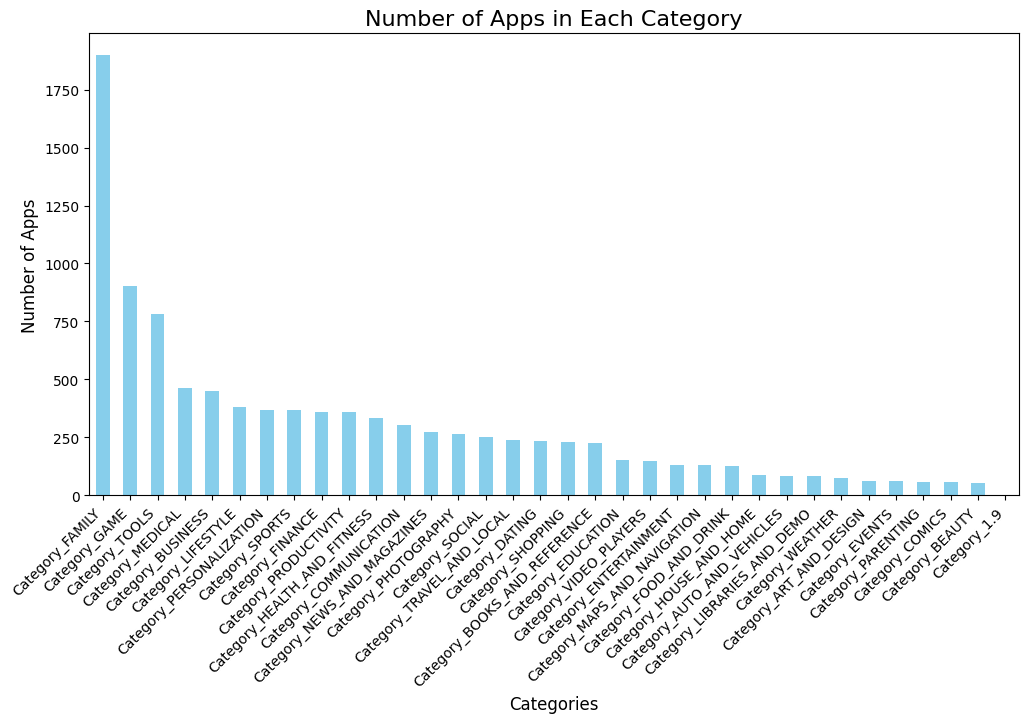

In [ ]:
df_one_hot = pd.get_dummies(apps_data, columns=['Category'])

category_counts = df_one_hot.filter(like='Category_').sum()

category_counts.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Number of Apps in Each Category', fontsize=16)
plt.xlabel('Categories', fontsize=12)
plt.ylabel('Number of Apps', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

#Data Integration
duplicate
chi-square
Correlation Matrix

In [ ]:
duplicates = reviews_data.duplicated()

num_duplicates = duplicates.sum()

print(f"Number of duplicate rows: {num_duplicates}")
from IPython.display import display

grouped_duplicates = reviews_data[reviews_data.duplicated()].groupby(['App']).agg({
    'Translated_Review': 'nunique',
    'Sentiment': 'nunique',
    'Sentiment_Polarity': ['mean', 'std'],
    'Sentiment_Subjectivity': ['mean', 'std']
})

styled_duplicates = grouped_duplicates.style.background_gradient(cmap='coolwarm').set_table_attributes("style='display:inline'")

display(styled_duplicates)


Number of duplicate rows: 33616


Skewness of numerical columns:
Reviews     6.819680
Size        1.653988
Installs    1.784207
dtype: float64


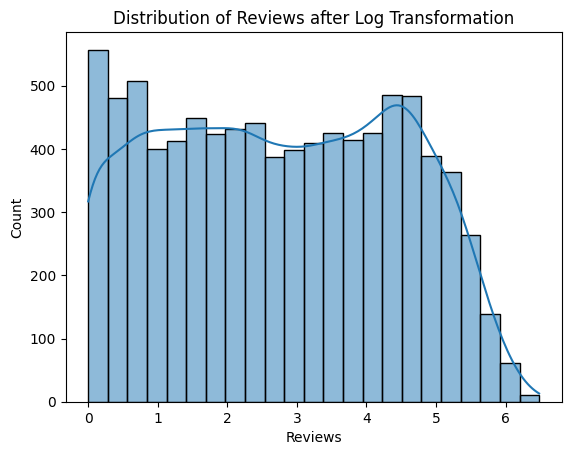

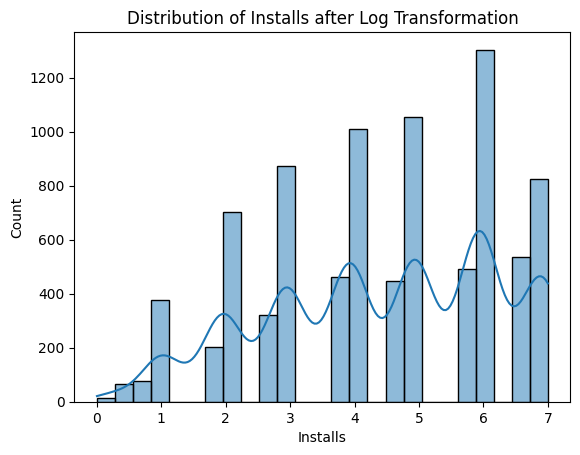

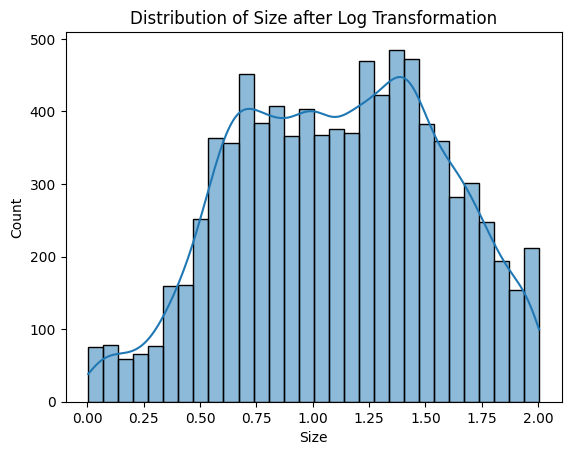

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

numerical_columns = ['Reviews', 'Size', 'Installs']

skewness = apps_data[numerical_columns].skew()

print("Skewness of numerical columns:")
print(skewness)

transformed_data = apps_data[numerical_columns].dropna().copy()

for col in numerical_columns:
    if skewness[col] > 1:
        transformed_data[col] = np.log10(transformed_data[col] + 1)
    elif skewness[col] < -1:
        transformed_data[col] = np.log10(transformed_data[col] + 1)

sns.histplot(transformed_data['Reviews'], kde=True)
plt.title('Distribution of Reviews after Log Transformation')
plt.show()

sns.histplot(transformed_data['Installs'], kde=True)
plt.title('Distribution of Installs after Log Transformation')
plt.show()

sns.histplot(transformed_data['Size'], kde=True)
plt.title('Distribution of Size after Log Transformation')
plt.show()


In [ ]:
apps_data = apps_data.drop(index=[10472])

In [ ]:
apps_data.head(2)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Rating_Binned,Cluster
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19.0,10000.0,Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,High,0
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14.0,500000.0,Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,Average,0


Chi-Square Test:
Statistic: 26.21942808733676, P-value: 8.090299941088211e-05
Reviews    0
Rating     0
dtype: int64
Pearson Correlation between Rating and Reviews: 0.14661981400410448


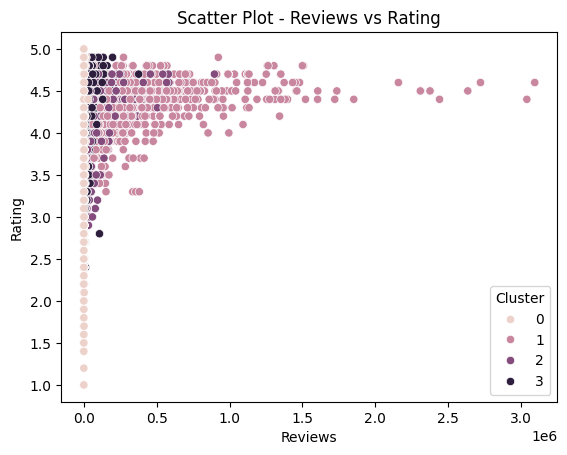

Covariance Matrix:
                Rating       Reviews
Rating       0.242241  1.316950e+04
Reviews  13169.499225  3.330468e+10


In [ ]:
from scipy.stats import chi2_contingency, pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

# 2.1 Chi-Square Test (for nominal data)
contingency_table = pd.crosstab(apps_data['Type'], apps_data['Content Rating'])
chi2, p, _, _ = chi2_contingency(contingency_table)
print("Chi-Square Test:")
print(f"Statistic: {chi2}, P-value: {p}")

apps_data['Reviews'] = pd.to_numeric(apps_data['Reviews'], errors='coerce')
print(apps_data[['Reviews', 'Rating']].isna().sum())
corr, _ = pearsonr(apps_data['Rating'], apps_data['Reviews'])
print(f"Pearson Correlation between Rating and Reviews: {corr}")

sns.scatterplot(data=apps_data, x='Reviews', y='Rating', hue='Cluster')
plt.title('Scatter Plot - Reviews vs Rating')
plt.show()

covariance = apps_data[['Rating', 'Reviews']].cov()
print("Covariance Matrix:\n", covariance)


Covariance between Rating and Reviews: 0.099
Correlation between Rating and Reviews: 0.115
--------------------------------------------------
Covariance between Size and Installs: 0.237
Correlation between Size and Installs: 0.290
--------------------------------------------------
Covariance between Installs and Rating: 0.028
Correlation between Installs and Rating: 0.031
--------------------------------------------------
Covariance between Reviews and Installs: 2.898
Correlation between Reviews and Installs: 0.955
--------------------------------------------------


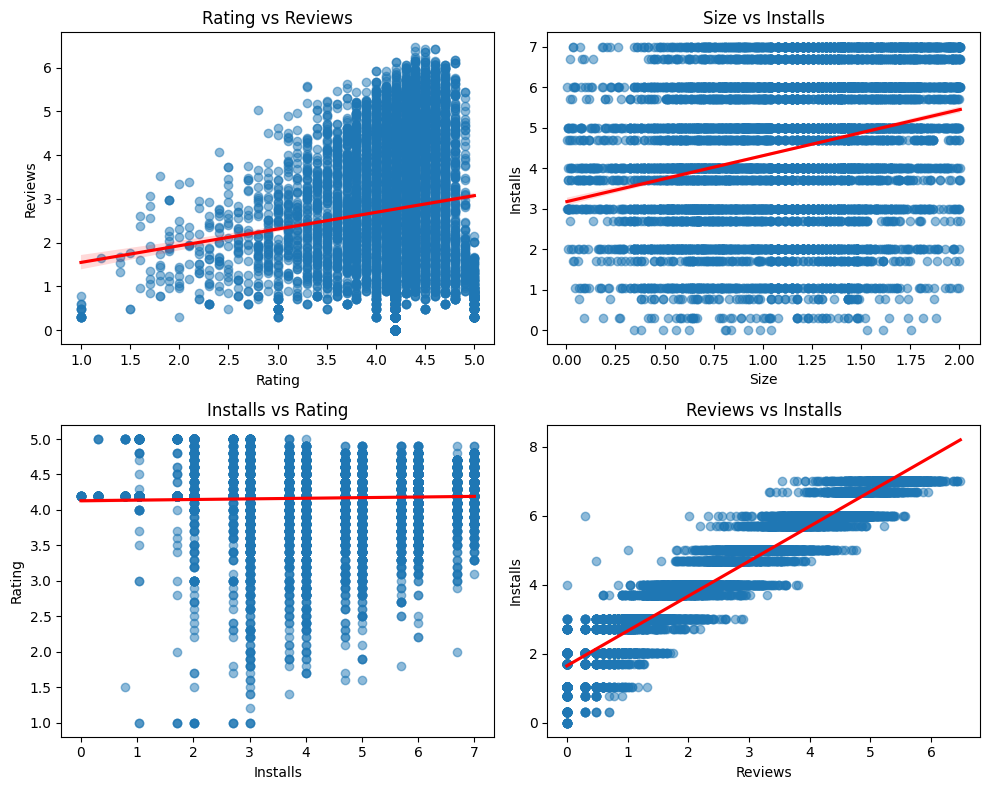

In [ ]:
numerical_columns = ['Reviews', 'Size', 'Installs', 'Android Ver']

transformed_data = apps_data[numerical_columns].dropna().copy()
transformed_data['Reviews'] = np.log10(transformed_data['Reviews'] + 1)
transformed_data['Installs'] = np.log10(transformed_data['Installs'] + 1)
transformed_data['Size'] = np.log10(transformed_data['Size'] + 1)
transformed_data['Rating']= apps_data['Rating']

columns_to_analyze = [
    ('Rating', 'Reviews'),
    ('Size', 'Installs'),
    ('Installs', 'Rating'),
    ('Reviews', 'Installs')
]
for col1, col2 in columns_to_analyze:
    cov_value = transformed_data[[col1, col2]].cov().iloc[0, 1]
    corr_value = transformed_data[[col1, col2]].corr().iloc[0, 1]
    print(f"Covariance between {col1} and {col2}: {cov_value:.3f}")
    print(f"Correlation between {col1} and {col2}: {corr_value:.3f}")
    print('-' * 50)

plt.figure(figsize=(10, 8))
for i, (col1, col2) in enumerate(columns_to_analyze, start=1):
    plt.subplot(2, 2, i)
    sns.regplot(
        x=col1, y=col2, data=transformed_data,
        scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'}
    )
    plt.title(f'{col1} vs {col2}')
    plt.xlabel(f'{col1}')
    plt.ylabel(f'{col2}')
plt.tight_layout()
plt.show()

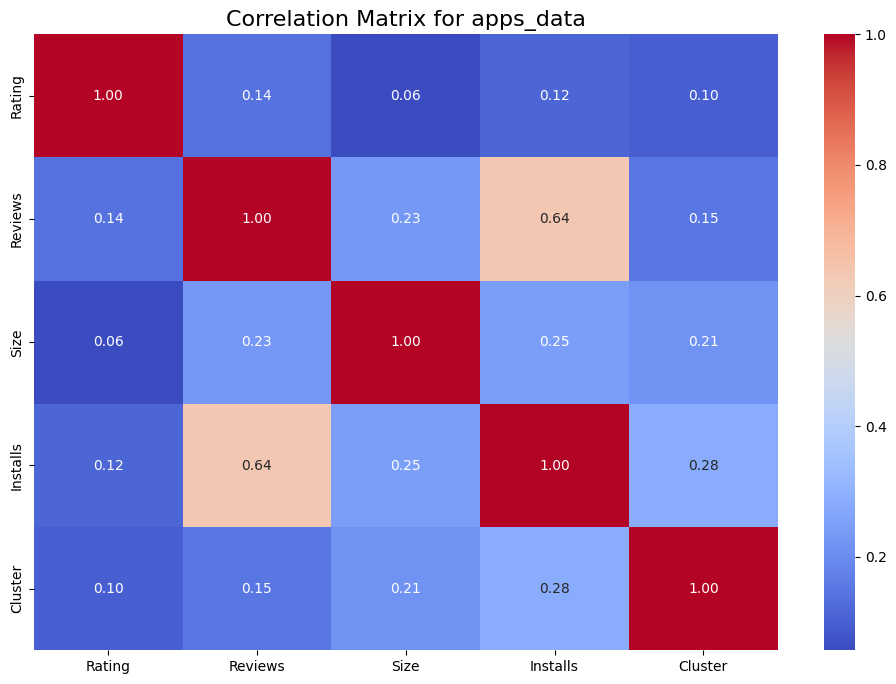

In [ ]:
# Generate correlation matrix
correlation_matrix = apps_data.corr(numeric_only=True)

# Display the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix for apps_data', fontsize=16)
plt.show()


#Data Reduction

Explained Variance Ratios: [0.97556667 0.01761145]
Sampled Data Shape: (1001, 15)


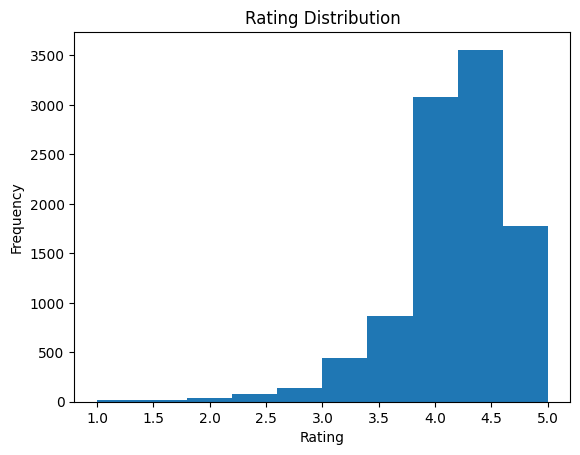

In [ ]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
print("Explained Variance Ratios:", pca.explained_variance_ratio_)

sampled_apps_data = apps_data.sample(frac=0.1, random_state=42)
print("Sampled Data Shape:", sampled_apps_data.shape)

apps_data['Rating'].plot(kind='hist', bins=10, title='Rating Distribution')
plt.xlabel('Rating')
plt.show()


#Data Transformation and Discretization

    Installs  Normalized_Installs_MinMax  Normalized_Installs_ZScore  \
0    10000.0                       0.001                   -0.542186   
1   500000.0                       0.050                   -0.395904   
2  5000000.0                       0.500                    0.947507   
4   100000.0                       0.010                   -0.515318   
5    50000.0                       0.005                   -0.530245   

   Normalized_Installs_Decimal  
0                       0.0001  
1                       0.0050  
2                       0.0500  
4                       0.0010  
5                       0.0005  


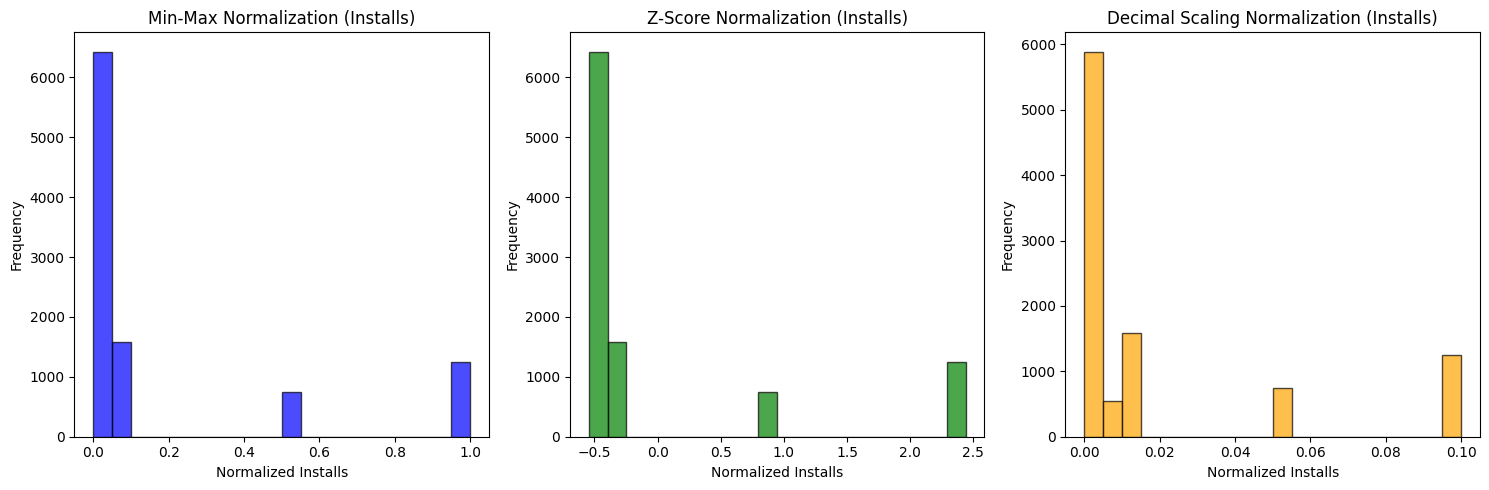

In [ ]:

apps_data['Installs'] = apps_data['Installs'].replace({'[+,]': ''}, regex=True).astype(float)

apps_data = apps_data.dropna(subset=['Installs'])

min_max_scaler = MinMaxScaler()
apps_data['Normalized_Installs_MinMax'] = min_max_scaler.fit_transform(apps_data[['Installs']])

z_score_scaler = StandardScaler()
apps_data['Normalized_Installs_ZScore'] = z_score_scaler.fit_transform(apps_data[['Installs']])

def decimal_scaling(series):
    max_abs_value = series.abs().max()
    scaling_factor = len(str(int(max_abs_value)))
    return series / (10**scaling_factor)

apps_data['Normalized_Installs_Decimal'] = decimal_scaling(apps_data['Installs'])

print(apps_data[['Installs', 'Normalized_Installs_MinMax', 'Normalized_Installs_ZScore', 'Normalized_Installs_Decimal']].head())

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(apps_data['Normalized_Installs_MinMax'], bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title('Min-Max Normalization (Installs)')
plt.xlabel('Normalized Installs')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(apps_data['Normalized_Installs_ZScore'], bins=20, color='green', alpha=0.7, edgecolor='black')
plt.title('Z-Score Normalization (Installs)')
plt.xlabel('Normalized Installs')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(apps_data['Normalized_Installs_Decimal'], bins=20, color='orange', alpha=0.7, edgecolor='black')
plt.title('Decimal Scaling Normalization (Installs)')
plt.xlabel('Normalized Installs')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:

bins_installs = [0, 10000, 1000000, 10000000, np.inf]
labels_installs = ['Low', 'Medium', 'High', 'Very High']
apps_data['Install_Hierarchy'] = pd.cut(apps_data['Installs'], bins=bins_installs, labels=labels_installs)

bins_size = [0, 5, 50, 100, np.inf]
labels_size = ['Small', 'Medium', 'Large', 'Very Large']
apps_data['Size_Hierarchy'] = pd.cut(apps_data['Size'], bins=bins_size, labels=labels_size)

print(apps_data[['Installs', 'Size', 'Install_Hierarchy', 'Size_Hierarchy']].head())



    Installs  Size Install_Hierarchy Size_Hierarchy
0    10000.0  19.0               Low         Medium
1   500000.0  14.0            Medium         Medium
2  5000000.0   8.7              High         Medium
4   100000.0   2.8            Medium          Small
5    50000.0   5.6            Medium         Medium


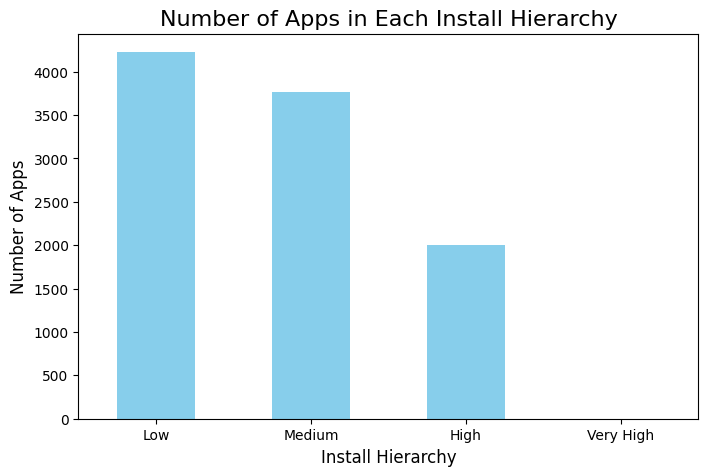

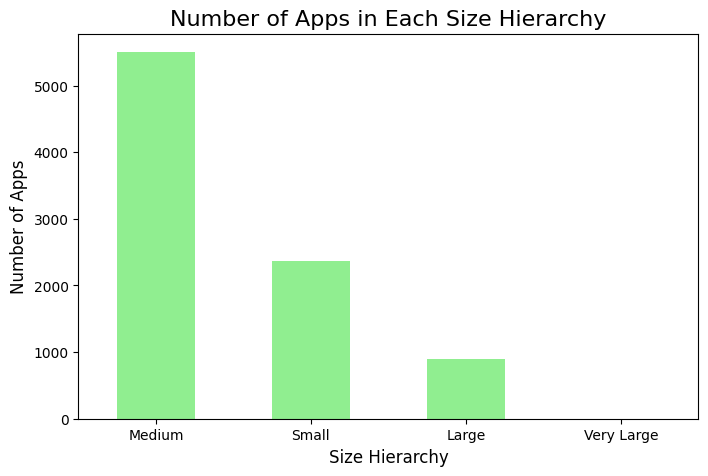

In [ ]:
import matplotlib.pyplot as plt

install_counts = apps_data['Install_Hierarchy'].value_counts()

install_counts.plot(kind='bar', color='skyblue', figsize=(8, 5))
plt.title('Number of Apps in Each Install Hierarchy', fontsize=16)
plt.xlabel('Install Hierarchy', fontsize=12)
plt.ylabel('Number of Apps', fontsize=12)
plt.xticks(rotation=0)
plt.show()

size_counts = apps_data['Size_Hierarchy'].value_counts()

size_counts.plot(kind='bar', color='lightgreen', figsize=(8, 5))
plt.title('Number of Apps in Each Size Hierarchy', fontsize=16)
plt.xlabel('Size Hierarchy', fontsize=12)
plt.ylabel('Number of Apps', fontsize=12)
plt.xticks(rotation=0)
plt.show()
